# Working with Uganda Dataset

## Name: Victor Agaba

## Date: 2024-08-12

***

In [49]:
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as sm
from package import optimizer as opt
from package import plots
import numpy as np, pandas as pd

***
#### Data Preprocessing
***

In [50]:
# read in the data
data_path = '../data/ug_data.csv'
data = pd.read_csv(data_path, header=0)
data = data.replace(np.nan, '', regex=True)

# shift errors to their own columns
amp_types = ['Raw', 'LP', 'BP']
og_cols = []
error_cols = []
for col in data.columns:
    for amp_type in amp_types:
        if amp_type in col:
            og_cols.append(col)
            error_cols.append(f'{col} error')

for col in error_cols:
    data[col] = np.nan

for i in range(1, len(data), 2):
    for j in range(len(og_cols)):
        data.at[i, error_cols[j]] = data.at[i-1, og_cols[j]]

data = data.drop(data.index[::2])
data.index = range(len(data))

print(data.head())

  Item    Event Id Magnitude      Origin time Longitude Latitude Depth  \
0  8.0  usp000a8sp       4.9  1/31/2001 19:15    29.494    0.466  27.7   
1  7.0  usp000hx9x       5.0   3/15/2011 3:25    31.231    1.746  10.0   
2  6.0  usb000i4t5       5.2   7/2/2013 13:33    30.907    1.606  10.0   
3  5.0  usb000i67t       5.7   7/3/2013 19:21    30.894    1.537  10.1   
4  4.0  usb000i6hl       5.1   7/3/2013 22:22    30.818    1.548  10.0   

  Station Location Azimuth: BHR  ... Raw: SH error Raw: SZ error LP: P error  \
0    MBAR   Uganda        129.0  ...       28400.0       30000.0       191.0   
1    KMBO      DRC        115.0  ...        4810.0        3570.0      2580.0   
2    MBAR   Uganda        186.0  ...      210000.0      214000.0     12200.0   
3    MBAR   Uganda        184.0  ...      756000.0      645000.0     12000.0   
4    MBAR   Uganda        185.0  ...      312000.0      288000.0      4160.0   

  LP: SV error LP: SH error LP: SZ error BP: P error  BP: SV error  \
0   

***
#### Source Mechanism
***

In [ ]:
idx = 8

# # BUG: fix model.filter_outliers
# # maybe don't use a statistical threshold
# # make sure they're all of one type
# idx = 3
# idx = 8

az_type = 'BHR'
azimuth = data.iloc[idx][f'Azimuth: {az_type}']
wave_types = ['P', 'S']
takeoff_angles = [data.iloc[idx][f'Takeoff: {wave_type}n'] for wave_type in wave_types]
velocities = np.array([5.80, 3.46])

# need to correct for measurement stuff
amp_type = 'Raw'
amps = ['P', 'SV', 'SH']
Ao = np.array([data.iloc[idx][f'{amp_type}: {amp}'] for amp in amps])
Uo = np.array([data.iloc[idx][f'{amp_type}: {amp} error'] for amp in amps])

***
#### Hybrid Inversion
***

In [52]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
inv_model.set_Ao(Ao)


# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 100
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.get_convergence_rate():.0f}%')

Run 0 of 100
Run 10 of 100
Run 20 of 100
Run 30 of 100
Run 40 of 100
Run 50 of 100
Run 60 of 100
Run 70 of 100
Run 80 of 100
Run 90 of 100
Convergence rate: 95%


Axis: T
Optimal parameters: [85.8981164  15.7398009  43.28299472]
Search error: 21.292174776524952 degrees


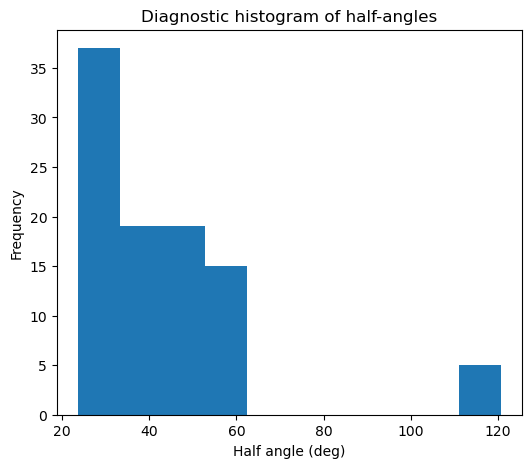

In [53]:
params, error, position = inv_model.get_optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

plots.half_angles(inv_model, bins=10)

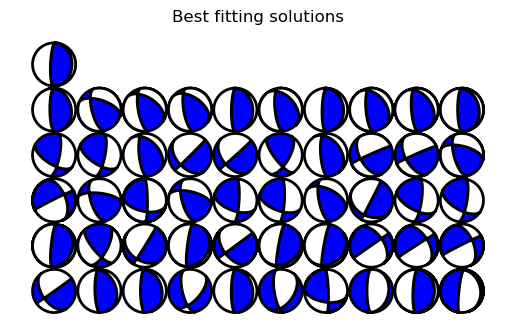

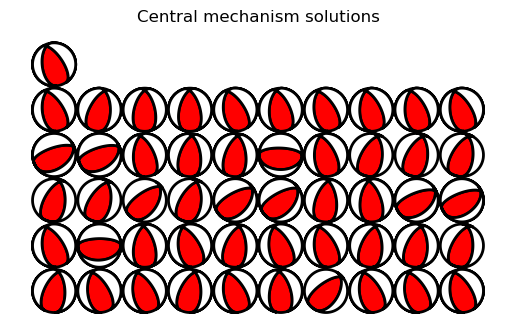

In [54]:
# beachball plots
plots.beachballs(inv_model, central=False, order_by='strike')
plots.beachballs(inv_model, central=True, order_by='strike')

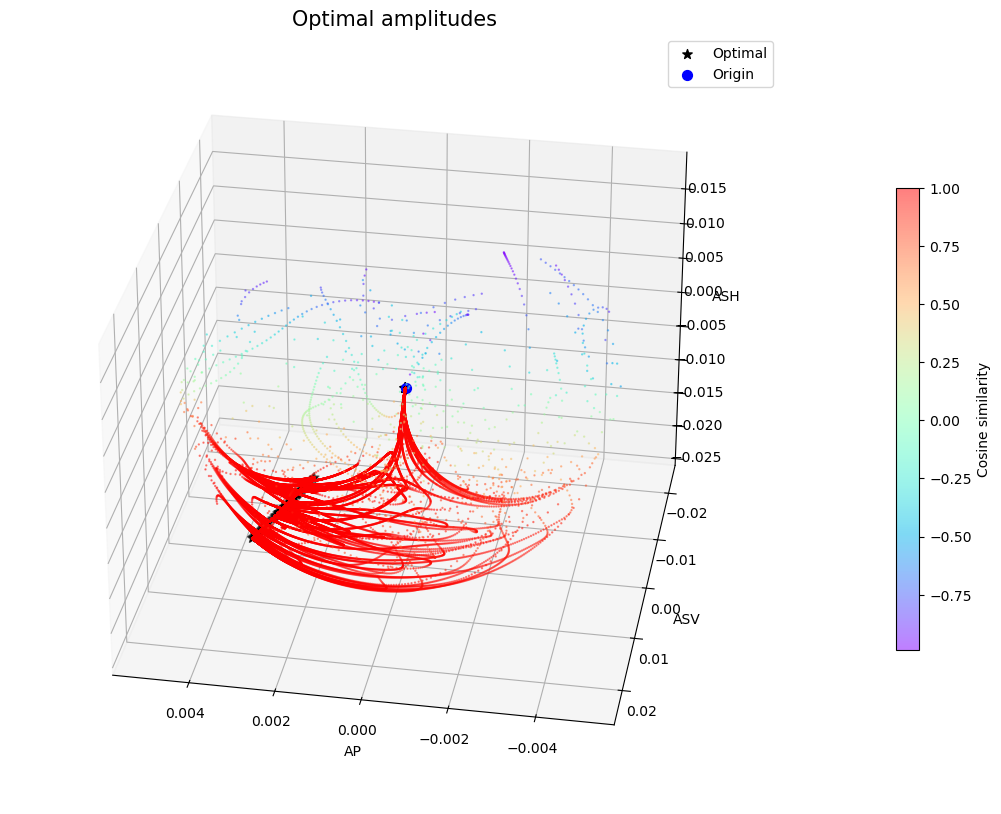

In [55]:
# amplitude plot
plots.amplitudes(inv_model, azim=100, elev=30, s=50, alpha=0.5, iterates=True, observed=False)

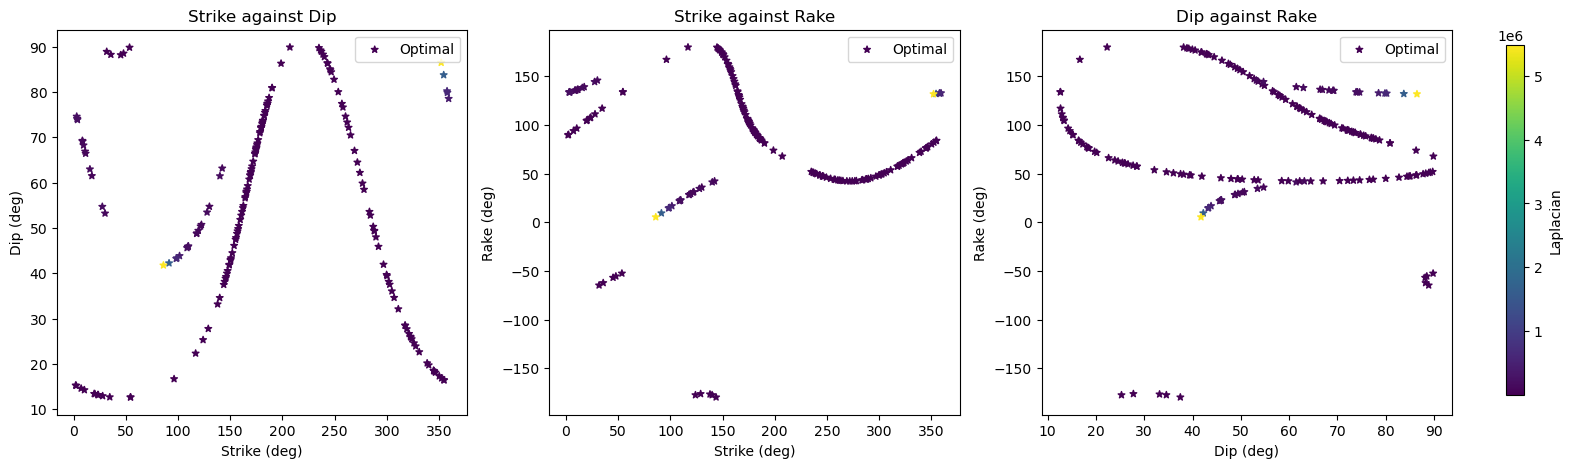

In [56]:
# iterate plot - sdr space
plots.iterates_2D(inv_model, s=25, optimal=True, index=2, cmap='viridis')
# plots.iterates_2D(inv_model, s=1, optimal=False, index=0)
# plots.iterates_2D(inv_model, s=1, optimal=False, index=1)

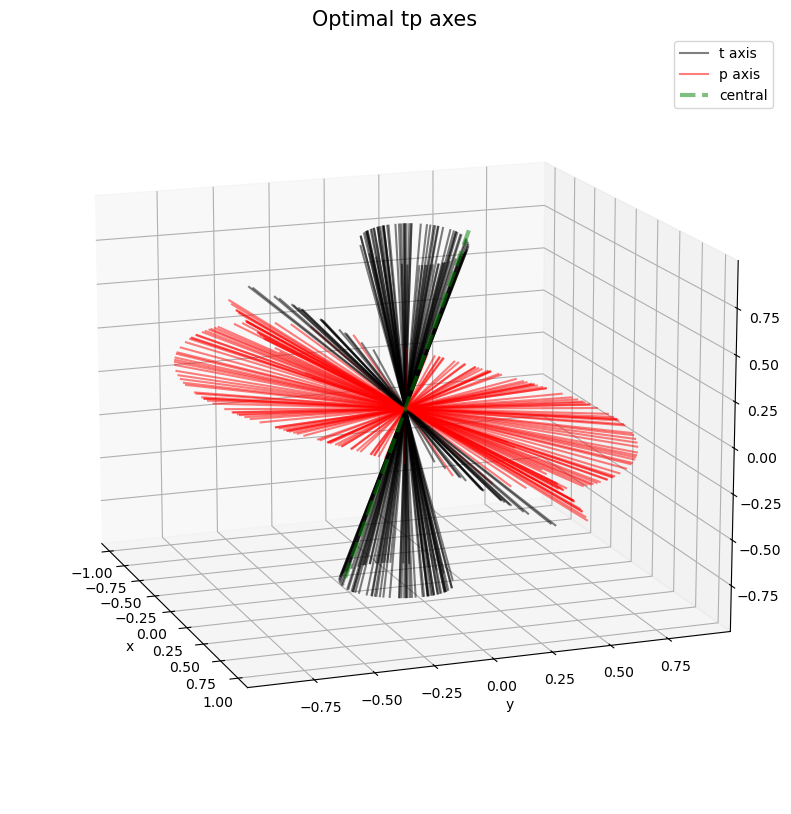

In [57]:
# optimal plot - tp space, collapse to central
plots.tp_axes(inv_model, azim=-20, elev=15, half=False, central=False)

***
#### Uncertainty Propagation
***

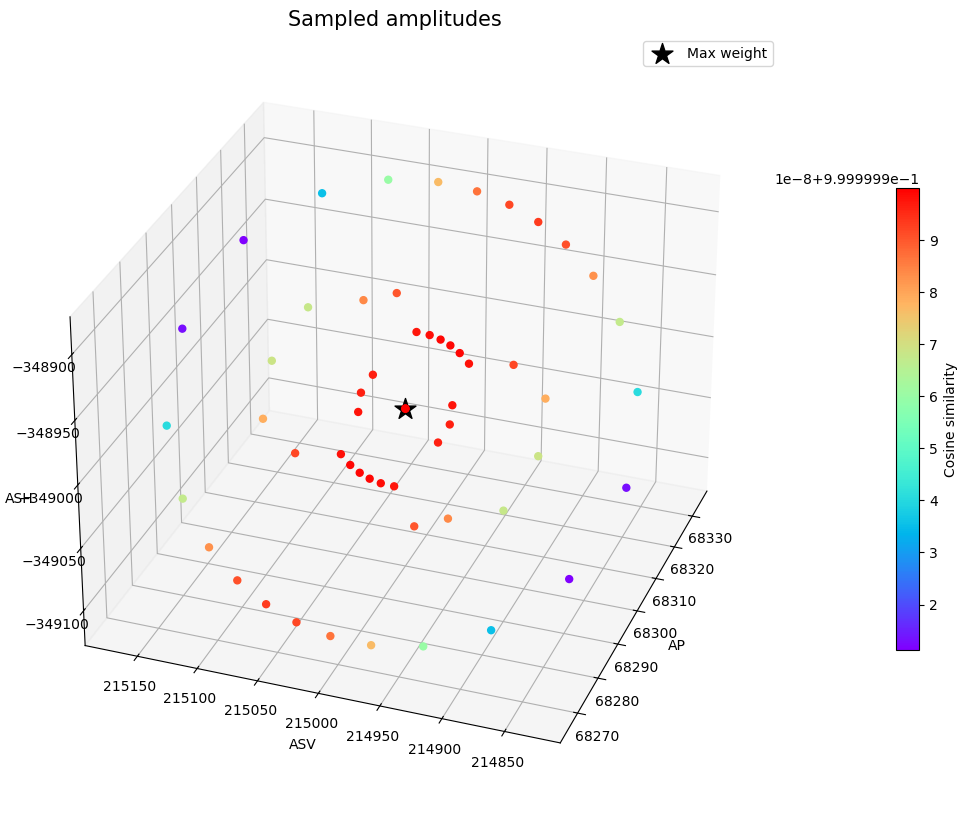

In [58]:
dd, num_samples = 15, 50
# dd, num_samples = 30, 15  # debugging
inv_model.set_Uo(Uo)
inv_model.set_chi2()
inv_model.sample_amplitudes(dd, num_samples)
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

In [ ]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 57
Sample 1 of 57
Sample 2 of 57
Sample 3 of 57
Sample 4 of 57
Sample 5 of 57
Sample 6 of 57
Sample 7 of 57
Sample 8 of 57
Sample 9 of 57
Sample 10 of 57
Sample 11 of 57
Sample 12 of 57
Sample 13 of 57
Sample 14 of 57
Sample 15 of 57
Sample 16 of 57
Sample 17 of 57
Sample 18 of 57
Sample 19 of 57
Sample 20 of 57
Sample 21 of 57
Sample 22 of 57
Sample 23 of 57
Sample 24 of 57
Sample 25 of 57
Sample 26 of 57
Sample 27 of 57
Sample 28 of 57
Sample 29 of 57
Sample 30 of 57
Sample 31 of 57
Sample 32 of 57
Sample 33 of 57
Sample 34 of 57
Sample 35 of 57
Sample 36 of 57
Sample 37 of 57
Sample 38 of 57
Sample 39 of 57
Sample 40 of 57
Sample 41 of 57
Sample 42 of 57
Sample 43 of 57
Sample 44 of 57
Sample 45 of 57
Sample 46 of 57
Sample 47 of 57
Sample 48 of 57
Sample 49 of 57


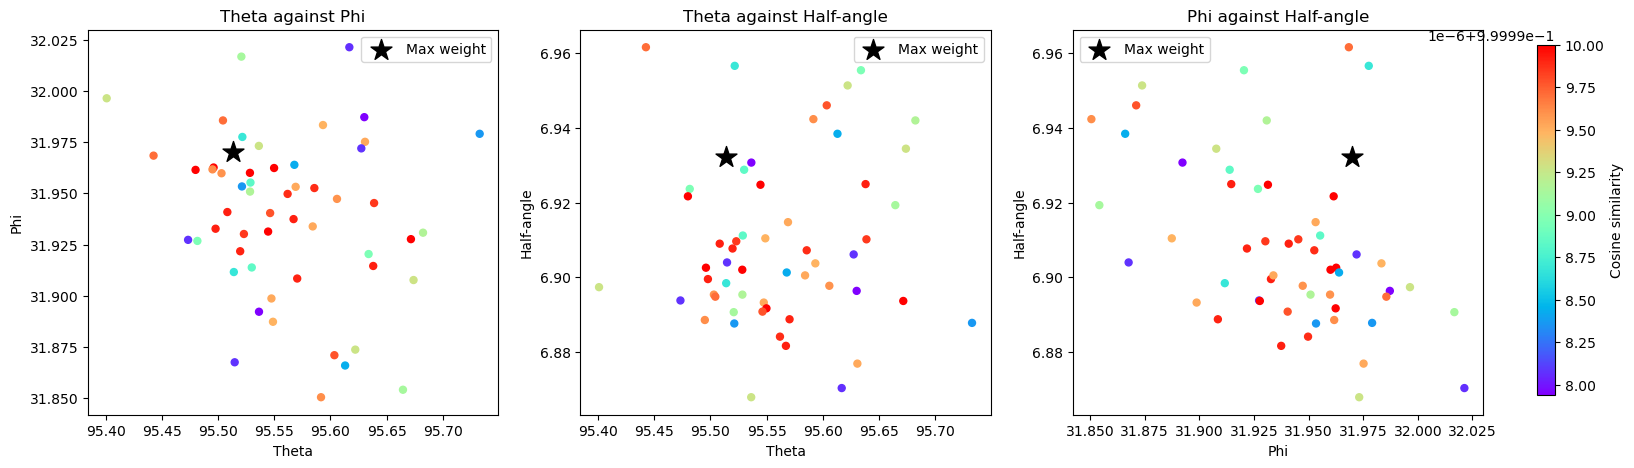

In [ ]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
plots.uncertainty_2D(inv_model, s=25, scale=0)
# plots.uncertainty_3D(inv_model, elev=30, azim=45, s=25)

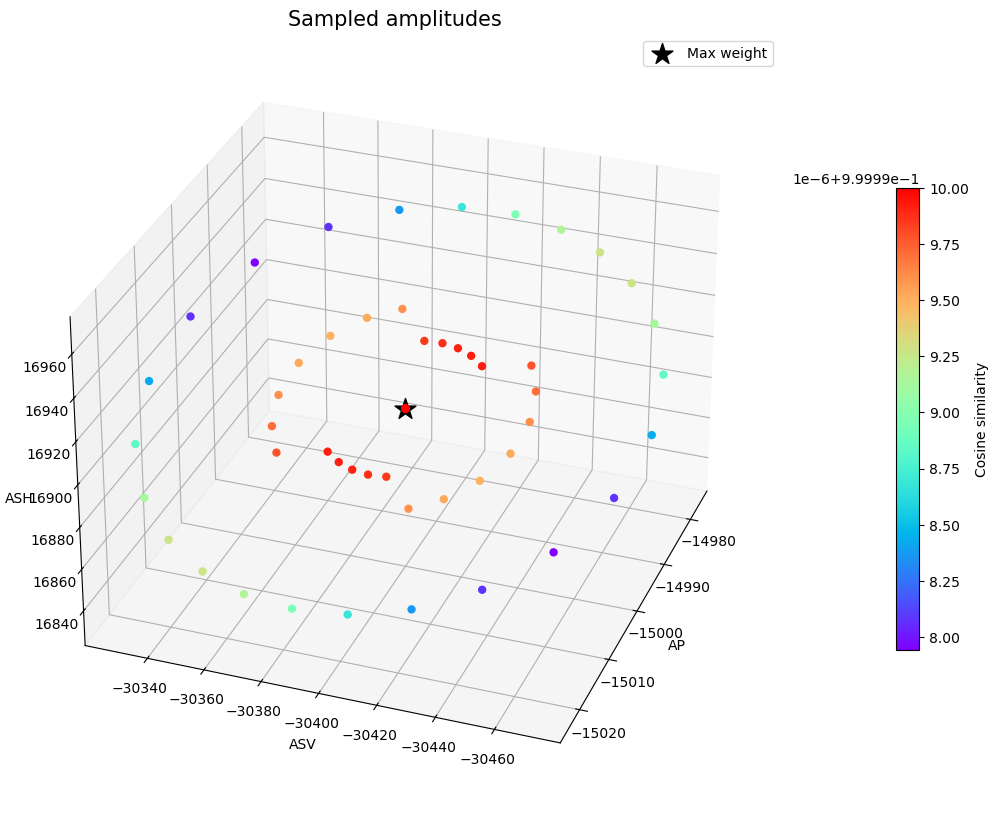

In [ ]:
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

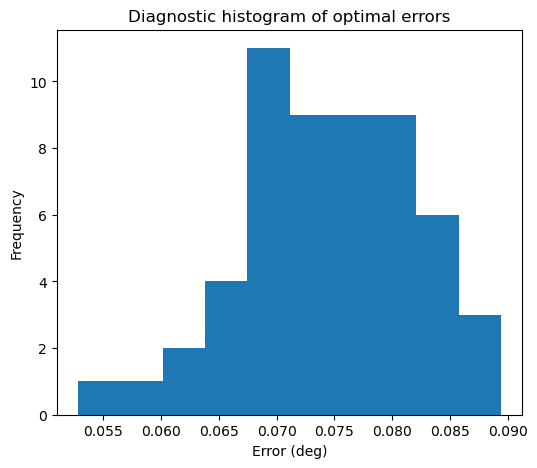

In [ ]:
# diagnostic plot of monte carlo errors
plots.optimal_errors(inv_model, bins=10)

***
INSIGHTS:
* For very small errors, we can still approximate a covariance ellipse using PCA
* Laplacian generally points away from the transformation's center of mass
* Include alpha level on uncertainty plot (perhaps split by mode)
* See if the central mechanisms are really Kagan angles
* The modes are begging to show on a continuum!
* Observations are so much bigger than simulations for idx=0

***